<a href="https://colab.research.google.com/github/WhiteWolf088/Milestone_Projects/blob/main/Food_Vision%E2%84%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU

In [3]:
!nvidia-smi

Fri Jan 14 02:50:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Using Tensorflow Datasets to Download Data

In [4]:
# Get Tensorflow Datasets 
import tensorflow_datasets as tfds

In [5]:
#List of Tensorflow Datasets
datasets_list=tfds.list_builders()
datasets_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc']

In [6]:
# Check for our Dataset 
print('food101' in datasets_list)

True


In [7]:
# Load in the Data
(train_data,test_data),ds_info=tfds.load(name='food101',
                                         split=['train','validation'],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete7F1M40/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete7F1M40/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from Tensorflow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data(image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels matches up with the class names?

In [8]:
#Features of Food101 fro TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
#Get the Class names
class_names=ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# One sample of the data
train_one_sample=train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
for image,label in train_one_sample:
  print(f"""
  Image Shape :{image.shape}
  Image datatype :{image.dtype}
  Target class from Food101 (Tensor form) :{label}
  class name (str form) :{class_names[label.numpy()]}
  """)


  Image Shape :(512, 512, 3)
  Image datatype :<dtype: 'uint8'>
  Target class from Food101 (Tensor form) :77
  class name (str form) :pork_chop
  


In [12]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [13]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

(-0.5, 511.5, 511.5, -0.5)

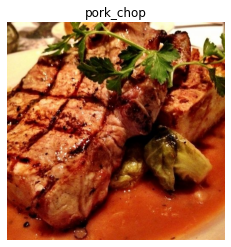

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing functions for our data

Neural networks perform best when data is in certain way (e.g. batched, normalised, etc).

However, not all data(including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, we'll often have to write preprocessing functions and map it to our data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `Float32` dtype (or for mixed precision `Float16` and `float32`)
* For batches, Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function

Since we are going to be using an `EfficientNetBX` pretrained model from `tf.keras.applications` we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`


In [15]:
# Make a function for preprocessing images
def preprocess_img(image,label,img_shape=224):
  """
  Convert image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, colour_channels]
  """
  image=tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32),label #return (float32_image,label) tuple
  

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img=preprocess_img(image, label)[0]
print(f'Image before preprocessing :\n{image[:2]}...,\nShape : {image.shape},\nDatatype : {image.dtype}\n')
print(f'Image after preprocessing :\n{preprocessed_img[:2]}...,\nShape : {preprocessed_img.shape},\nDatatype : {preprocessed_img.dtype}\n')

Image before preprocessing :
[[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]...,
Shape : (512, 512, 3),
Datatype : <dtype: 'uint8'>

Image after preprocessing :
[[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]...,
Shape : (224, 224, 3),
Datatype : <dtype: 'float32'>



## Batch & Prepare Datasets

we're now going to make our data input pipeline run really fast

In [17]:
# Map preprocessing function to training (parallelize)
train_data=train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load_it faster)
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data=test_data.map(preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [19]:
test_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results(so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [20]:
# TensorBoard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [21]:
# ModelCheckpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1) 

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Setup Mixed precision training

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance.

In [24]:
# Turn on mixed precision training 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Feature Extraction 

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [26]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [27]:
history=model.fit(train_data,
                  epochs=3,
                  steps_per_epoch=len(train_data),
                  validation_data=test_data,
                  validation_steps=int(0.15*len(test_data)),
                  callbacks=[create_tensorboard_callback('training_logs',
                                                         'feature_extraction_101_all_data'),
                             model_checkpoint])

Saving TensorBoard log files to: training_logs/feature_extraction_101_all_data/20220114-030047
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 1.8199 - accuracy: 0.5575
Epoch 00001: val_loss improved from inf to 1.22817, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 184s 71ms/step - loss: 1.8199 - accuracy: 0.5575 - val_loss: 1.2282 - val_accuracy: 0.6772
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2927 - accuracy: 0.6660
Epoch 00002: val_loss improved from 1.22817 to 1.13369, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 162s 68ms/step - loss: 1.2927 - accuracy: 0.6660 - val_loss: 1.1337 - val_accuracy: 0.6970
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1427 - accuracy: 0.7017
Epoch 00003: val_loss improved from 1.13369 to 1.08185, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 161s 67ms/step - loss: 1.1427 - accuracy: 0.7017 - val_loss: 1.0819 - val_accuracy: 0.7071


In [28]:
model.evaluate(test_data)

790/790 [==============================] - 48s 61ms/step - loss: 1.0860 - accuracy: 0.7092


[1.085980772972107, 0.7091881036758423]

In [29]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

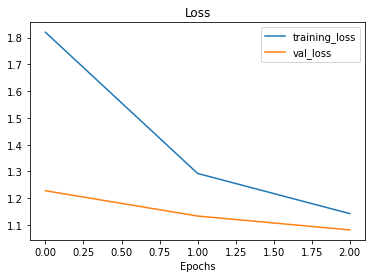

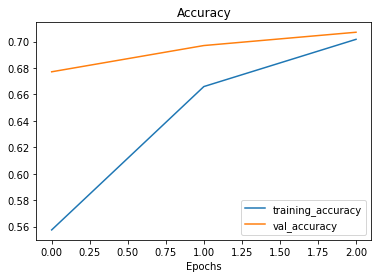

In [30]:
plot_loss_curves(history)

## Fine Tuning

In [31]:
for layer in base_model.layers:
  base_model.trainable=True

In [32]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [33]:
finetune_history=model.fit(train_data,
                           epochs=7,
                           initial_epoch=3,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=int(0.15*len(test_data)),
                           callbacks=[create_tensorboard_callback('training_logs',
                                                                  'finetune_101_all_data'),
                                      model_checkpoint,
                                      early_stopping,
                                      reduce_lr])

Saving TensorBoard log files to: training_logs/finetune_101_all_data/20220114-031102


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 4/7
2368/2368 [==============================] - ETA: 0s - loss: 0.9218 - accuracy: 0.7517
Epoch 00004: val_loss improved from 1.08185 to 0.80651, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 342s 138ms/step - loss: 0.9218 - accuracy: 0.7517 - val_loss: 0.8065 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 5/7
2367/2368 [============================>.] - ETA: 0s - loss: 0.5796 - accuracy: 0.8401
Epoch 00005: val_loss improved from 0.80651 to 0.78889, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 330s 139ms/step - loss: 0.5796 - accuracy: 0.8401 - val_loss: 0.7889 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 6/7
2368/2368 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.9049
Epoch 00006: val_loss did not improve from 0.78889
2368/2368 [==============================] - 330s 139ms/step - loss: 0.3309 - accuracy: 0.9049 - val_loss: 0.8716 - val_accuracy: 0.7820 - lr: 1.0000e-04


In [34]:
model.evaluate(test_data)

790/790 [==============================] - 47s 60ms/step - loss: 0.9626 - accuracy: 0.7843


[0.9626404047012329, 0.7842772006988525]

In [35]:
def compare_histories(original_history, new_history, initial_epochs):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

3
7
[0.5575049519538879, 0.6659933924674988, 0.7017293572425842, 0.7516567707061768, 0.8400791883468628, 0.9048581123352051, 0.9486732482910156]


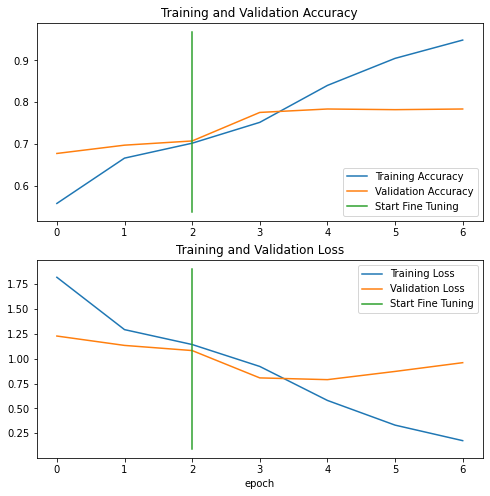

In [36]:
compare_histories(history,finetune_history,initial_epochs=3)

## Saving and Loading Model

In [37]:
# Downloading the model
model.save('Food Vision™.h5') # For External Download

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [38]:
model.save('/content/drive/MyDrive/Trained Models/Food Vision™') # Saving to drive

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Trained Models/Food Vision™/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Trained Models/Food Vision™/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [39]:
loaded_model=tf.keras.models.load_model('/content/drive/MyDrive/Trained Models/Food Vision™')

In [40]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 50s 62ms/step - loss: 0.9626 - accuracy: 0.7843


[0.9626399874687195, 0.7842772006988525]

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
   --one_shot

* To view Experiments in TensorBoard.dev visit
 --> https://tensorboard.dev/experiment/qBk4OBNRS1OQ26TAYu5N1A/

In [44]:
!tensorboard dev list

https://tensorboard.dev/experiment/qBk4OBNRS1OQ26TAYu5N1A/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   qBk4OBNRS1OQ26TAYu5N1A
	Created              2022-01-14 03:42:36 (50 seconds ago)
	Updated              2022-01-14 03:42:39 (47 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              42
	Tensor bytes         0
	Binary object bytes  2057117
https://tensorboard.dev/experiment/NvWUzanMRs2HPiZZzRC00g/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   NvWUzanMRs2HPiZZzRC00g
	Created              2022-01-14 03:40:50 (2 minutes ago)
	Updated              2022-01-14 03:40:52 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars             